In [98]:
import os

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from tqdm import tqdm

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone




## Setup

### Experiment settings

In [99]:
device = "cuda"

In [100]:
RUN_TSNE = True

# Non-disruptive cleanse
RUN_KNN = False
RUN_ENERGY = False
RUN_LOGREG = False

# Disruptive cleanse
RUN_CENTROID = False
RUN_GAUSS = True

DATASET = "sig"
TRAIN = False

if DATASET == "badnets":
    TARGET_CLASS = 1
    DATASET_NAME = "BadNets"
    SIMCLR_MODEL_NAME = "BadNets-SimCLR.pt"
elif DATASET == "wanet":
    TARGET_CLASS = 0
    DATASET_NAME = "WaNet"
    SIMCLR_MODEL_NAME = "WaNet-SimCLR.pt"
elif DATASET == "sig":
    TARGET_CLASS = 1
    DATASET_NAME = "SIG"
    SIMCLR_MODEL_NAME = "SIG-SimCLR.pt"
# add option for clean
else:
    raise Exception("Invalid dataset")

### Poison dataset

In [101]:
def prepare_poison_dataset() -> VisionDataset:
    clean_dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=TRAIN)

    if DATASET == "badnets":
        poison_dataset = BadNetsDataset(clean_dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
    elif DATASET == "wanet":
        poison_dataset = WaNetDataset(clean_dataset, TARGET_CLASS, seed=1)
    elif DATASET == "sig":
        poison_dataset = SIGDataset(clean_dataset, TARGET_CLASS, 20, 6, seed=1)
    else:
        raise Exception("Invalid dataset")

    poison_indices = np.array([poison_dataset.is_poison(i) for i in range(len(poison_dataset))])

    return poison_dataset, poison_indices

dataset, poison_indices = prepare_poison_dataset()
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Load SimCLR model

In [102]:
def load_model(simclr_model_name: str) -> SimClrBackbone:
    model = SimClrBackbone()
    out = os.path.join('./saved_models/', simclr_model_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model

model = load_model(SIMCLR_MODEL_NAME)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Extract SimCLR features for all images

In [103]:
def extract_simclr_features(model: SimClrBackbone, dataset: VisionDataset):

    simclr_feature_size = 128
    num_examples = len(dataset)

    features = np.zeros((num_examples, simclr_feature_size))
    labels_poison = np.zeros((num_examples))
    labels_true = np.zeros((num_examples))

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
        labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
        labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

    labels_poison = labels_poison.astype(int)
    labels_true = labels_poison.astype(int)

    return features, labels_poison, labels_true

features, labels_poison, labels_true = extract_simclr_features(model, dataset)
num_classes = int(max(labels_poison).item())

### Plot t-SNE features

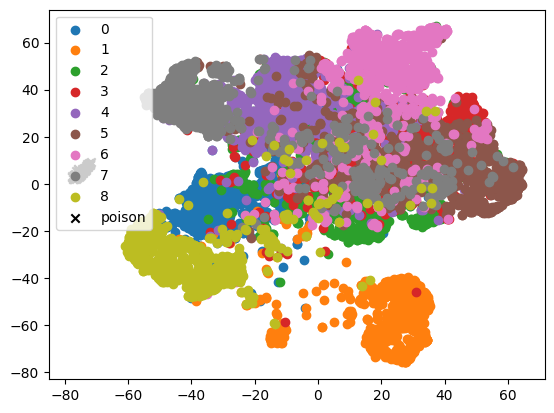

In [104]:
def plot_tsne(features: np.array, labels: np.array, poison_indices: np.array, subset_size: int = 10000) -> None:
    # label poison examples as 10
    labels = labels[:]
    labels[poison_indices] = 10

    # Plot only a subset
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
        
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features_subset)

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_subset==i,1], tsne_features[labels_subset==i,0])
    plt.scatter(tsne_features[labels_subset==10,1], tsne_features[labels_subset==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    return tsne_features


if RUN_TSNE:
    tsne_features = plot_tsne(features, labels_poison, poison_indices, subset_size=len(features))

In [105]:
print(tsne_features.shape)

(10000, 2)


## Step 1: Non-disruptive cleanse

In [106]:
def evaluate_cleanse(poison_predicted: np.array, poison_indices: np.array):
    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    print(f"{tp} \t {fp}")
    print(f"{fn} \t {tn}")
    print()
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

def save_predicted_labels(labels_predicted: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(labels_predicted, f)

### kNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cleanse(features: np.array, labels_poison: np.array, num_classes: int) -> np.array:
    
    examples_per_class = len(features) / num_classes
    knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
    knn.fit(features, labels_poison)
    labels_predicted = knn.predict(features)

    return labels_predicted

if RUN_KNN:
    labels_predicted_knn = knn_cleanse(features, labels_poison, num_classes)
    evaluate_cleanse(labels_predicted_knn != labels_poison, poison_indices)

    save_name = f"__NEW__{DATASET_NAME}-kNN-{'train' if TRAIN else 'test'}"
    save_predicted_labels(labels_predicted_knn, save_name)

------------------------------------

CIFAR-10 train \
BadNets 

    4905 	 9481
    95 	 35519
    Percentage of poisoned images (out of all poisoned) kept:  1.90%
    Percentage of clean images (out of all clean) kept:  78.93%
    Percentage of remaining poisoned images (out of all remaining):  0.27%

CIFAR-10 test \
BadNets 

    960 	 2056
    40 	 6944
    Percentage of poisoned images (out of all poisoned) kept:  4.00%
    Percentage of clean images (out of all clean) kept:  77.16%
    Percentage of remaining poisoned images (out of all remaining):  0.57%

------------------------------------

CIFAR-10 train \
WaNet 

    3975 	 14331
    1025 	 30669
    Percentage of poisoned images (out of all poisoned) kept:  20.50%
    Percentage of clean images (out of all clean) kept:  68.15%
    Percentage of remaining poisoned images (out of all remaining):  3.23%

CIFAR-10 test \
WaNet 

    712 	 3058
    288 	 5942
    Percentage of poisoned images (out of all poisoned) kept:  28.80%
    Percentage of clean images (out of all clean) kept:  66.02%
    Percentage of remaining poisoned images (out of all remaining):  4.62%

------------------------------------

CIFAR-10 train \
SIG

    0 	 9195
    500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

CIFAR-10 test \
SIG

    0 	 2179
    100 	 7721
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  77.99%
    Percentage of remaining poisoned images (out of all remaining):  1.28%


### Energy

In [108]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):
        # consider improving with numpy and batch

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

    def predict(self):
        predicted = np.zeros((len(self.X)))
        for i in range(len(self.X)):
            predicted[i] = self.predict_index(i)

In [109]:
def energy_cleanse(features: np.array, labels_poison: np.array) -> np.array:
    
    if DATASET == "badnets":
        T = 100
    elif DATASET == "wanet":
        T = 10
    elif DATASET == "sig":
        T = 1
    else:
        raise Exception("Invalid dataset")

    energy = EnergyClassifier(t=T)
    energy.fit(features, labels_poison)
    labels_predicted = energy.predict()

    return labels_predicted

if RUN_ENERGY:
    labels_predicted_energy = energy_cleanse(features, labels_poison)
    evaluate_cleanse(labels_predicted_energy != labels_poison, poison_indices)

    save_name = f"__NEW__{DATASET_NAME}-Energy-{'train' if TRAIN else 'test'}"
    save_predicted_labels(labels_predicted_knn, save_name)

CIFAR-10 train \
BadNets

	50000 / 50000
		4618 	 12732
		382 	 32268
	Percentage of poisoned images (out of all poisoned) kept:  7.64%
	Percentage of clean images (out of all clean) kept:  71.71%
	Percentage of remaining poisoned images (out of all remaining):  1.17%

CIFAR-10 test \
BadNets

	10000 / 10000
		920 	 2585
		80 	 6415
	Percentage of poisoned images (out of all poisoned) kept:  8.00%
	Percentage of clean images (out of all clean) kept:  71.28%
	Percentage of remaining poisoned images (out of all remaining):  1.23%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4725 	 14096
		275 	 30904
	Percentage of poisoned images (out of all poisoned) kept:  5.50%
	Percentage of clean images (out of all clean) kept:  68.68%
	Percentage of remaining poisoned images (out of all remaining):  0.88%

CIFAR-10 test \
WaNet

	10000 / 10000
		951 	 2851
		49 	 6149
	Percentage of poisoned images (out of all poisoned) kept:  4.90%
	Percentage of clean images (out of all clean) kept:  68.32%
	Percentage of remaining poisoned images (out of all remaining):  0.79%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

### LogReg 

In [110]:
# TODO cleanup, delete?

In [111]:
class LogReg(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)

In [112]:
class SimClrFeaturesDataset(VisionDataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    def __len__(self):
        return len(self.features)

In [113]:
if RUN_LOGREG:
    
    BATCH_SIZE = 1024
    NUM_MODELS = 10
    EPOCHS = 60

    classifications = np.zeros((NUM_MODELS, len(features)))

    for num_model in range(NUM_MODELS):
        print(f"Learning logistic regression model {num_model+1}/{NUM_MODELS}")
        simclr_features_dataset = SimClrFeaturesDataset(features, labels_poison)
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=True) 
        model = LogReg(128, 10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-1)
        criterion = torch.nn.CrossEntropyLoss()
        
        # train
        for epoch in range(EPOCHS):
            correct = 0
            for i, (batch_features, batch_labels) in enumerate(dataloader):
                batch_features, batch_labels = batch_features.float(), batch_labels.long()

                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == batch_labels).sum()
            accuracy = 100 * (correct.item()) / len(simclr_features_dataset)
        print(f"Accuracy: {accuracy}")

        # get model classifications
        dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=False) 
        for i, (batch_features, batch_labels) in enumerate(dataloader):
            batch_features, batch_labels = batch_features.float(), batch_labels.long()

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.numpy()
            classifications[num_model, (i*BATCH_SIZE):(i*BATCH_SIZE+len(predicted))] = predicted


In [114]:
if RUN_LOGREG:

    labels_poison_repeated = np.tile(labels_poison, (NUM_MODELS,1))
    misclassifications = np.sum(classifications != labels_poison_repeated, axis=0)

    misclassifications_poisoned = misclassifications[poison_indices]
    misclassifications_clean = misclassifications[np.invert(poison_indices)]

    # print(misclassifications_poisoned.shape)
    # print(misclassifications_clean.shape)

    # print(np.average(misclassifications_poisoned))
    # print(np.average(misclassifications_clean))

    bins = np.linspace(0, np.max(misclassifications), np.max(misclassifications))
    plt.hist(misclassifications_clean, bins, alpha=0.5, label='clean')
    plt.hist(misclassifications_poisoned, bins, alpha=0.5, label='poisoned')
    plt.legend(loc='upper right')
    plt.show()

In [115]:
if RUN_LOGREG:

    class_num = 1

    misclassifications_class = misclassifications[labels_poison == class_num]
    misclassifications_class_poisoned = misclassifications[np.logical_and(labels_poison == class_num, poison_indices)]
    misclassifications_class_clean = misclassifications[np.logical_and(labels_poison == class_num, np.invert(poison_indices))]

    print((labels_poison == class_num & np.invert(poison_indices)).shape)
    print(misclassifications_class.shape)
    print(misclassifications_class_poisoned.shape)
    print(misclassifications_class_clean.shape)

    bins = np.linspace(0, np.max(misclassifications_class), np.max(misclassifications_class))
    plt.hist(misclassifications_class_clean, bins, alpha=0.5, label='clean')
    plt.hist(misclassifications_class_poisoned, bins, alpha=0.5, label='poisoned')
    plt.legend(loc='upper right')
    plt.show()

## Disruptive detection

### Centroid

In [116]:
def plot_histogram_poisoned(values: np.array, poison_indices: np.array, is_integer: bool = False, bins_num: int = 100, separation_line: float = None) -> None:
    values_clean = values[np.invert(poison_indices)]
    values_poisoned = values[poison_indices]
    
    bins = np.linspace(int(np.min(values)), int(np.max(values)), int(np.max(values)) if is_integer else bins_num)
    plt.hist(values_clean, bins, alpha=0.5, label='clean')
    plt.hist(values_poisoned, bins, alpha=0.5, label='poisoned')

    if separation_line:
        plt.axvline(separation_line, color='red', linestyle='dashed', linewidth=1)

    plt.legend(loc='upper right')
    plt.show()

In [117]:
def centroid_cleanse(features: np.array) -> np.array:
    centroid = np.sum(features, axis=0) / features.shape[0]
    distances = np.linalg.norm(features - centroid, axis=1)
    
    plot_histogram_poisoned(distances, poison_indices)

if RUN_CENTROID:
    #centroid_cleanse(features)
    centroid_cleanse(tsne_features)

### Gauss 

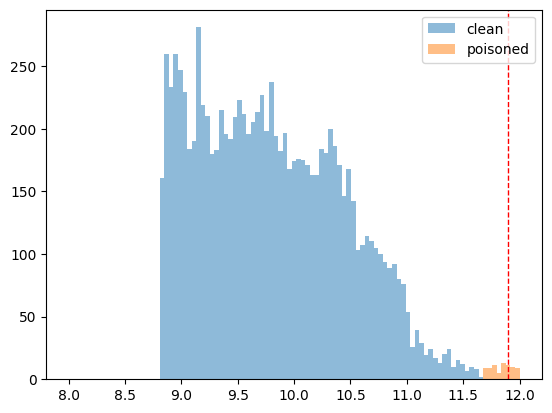

50 	 0
50 	 9900

Percentage of poisoned images (out of all poisoned) kept:  50.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  0.50%


In [175]:
from scipy.stats import multivariate_normal

def gauss_cleanse(features: np.array, discard_percentage: float) -> np.array:
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=0)

    probabilities = multivariate_normal.pdf(features, mean=mean, cov=cov, allow_singular=True)
    probabilities[probabilities <= 0] = 1e-100
    probabilities = -np.log(probabilities)

    discard_line = np.percentile(probabilities, (1-discard_percentage)*100)
    plot_histogram_poisoned(probabilities, poison_indices, separation_line=discard_line)

    predicted_poison_indices = probabilities > discard_line
    return predicted_poison_indices


if RUN_GAUSS:
    #gauss_cleanse(features)
    predicted_poison_indices = gauss_cleanse(tsne_features, 0.005)
    evaluate_cleanse(predicted_poison_indices==1, poison_indices)

## Poison reclassification

In [141]:
from typing import Any


class PoisonClassificationDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, poison_indices: np.array) -> None:
        self.original_dataset = original_dataset
        self.poison_indices = poison_indices

    def __len__(self) -> int:
        return len(self.original_dataset)
    
    def __getitem__(self, index: int) -> Any:
        return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])

### Weak binary classifier 

In [168]:
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

class ConvolutionalBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x) -> torch.tensor:
        return self.layers(x)

def train_binary_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    poison_classification_dataset = PoisonClassificationDataset(dataset, predicted_poison_indices)
    # sampler for class imbalance
    positives = sum([1 for _, target in poison_classification_dataset if target==1])
    total = len(poison_classification_dataset)
    positive_weight = 0.5 / positives
    negative_weight = 0.5 / (total - positives)
    weights = [positive_weight if target==1 else negative_weight for _, target in poison_classification_dataset]
    sampler = WeightedRandomSampler(weights, len(weights))

    dataloader = DataLoader(poison_classification_dataset, batch_size=128, sampler=sampler)
    model = ConvolutionalBinaryClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    num_epochs = 50

    for _ in tqdm(range(num_epochs)):
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            logits = model.forward(inputs).squeeze(-1)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model

def binary_reclassification(dataset: VisionDataset, model: nn.Module):
    predicted_poison_indices = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        logits = model.forward(inputs).squeeze(-1)
        predictions = (logits>0.5).cpu().numpy()
        predicted_poison_indices[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_poison_indices
        


In [176]:
model = train_binary_classifier(dataset, predicted_poison_indices)

C:\Users\Luka\AppData\Local\Temp\ipykernel_9256\3774959533.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])
100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


In [177]:
repredicted_poison_indices = binary_reclassification(dataset, model)
evaluate_cleanse(predicted_poison_indices==1, poison_indices)
print("=====")
evaluate_cleanse(repredicted_poison_indices==1, poison_indices)

50 	 0
50 	 9900

Percentage of poisoned images (out of all poisoned) kept:  50.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  0.50%
=====
100 	 6
0 	 9894

Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  99.94%
Percentage of remaining poisoned images (out of all remaining):  0.00%
